# Plots: heatmaps

In [1]:
import sys
sys.path.append("..\\source\\")
import utils as utils
import glob

# Data and numbers
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import MinMaxScaler

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.dates as mdates
mpl.style.use('ggplot')
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

# Palettes
from matplotlib.colors import ListedColormap
from palettable.colorbrewer.qualitative import Set2_8

In [2]:
# Pallete
cmap_orig = Set2_8.mpl_colors # callable
cmap = [cmap_orig[7],cmap_orig[6],cmap_orig[4],cmap_orig[3],cmap_orig[1],cmap_orig[0]]

In [3]:
path_data = "..\\data\\processed\\summary\\"
path_meta = "..\\data\\original\\metadata\\"
path_res = "..\\results\\"
path_fig = "..\\figures\\"

In [4]:
ref = {0:"normal", 1:"A", 2:"B", 3:"C", 4:"D", 5:"E"}
color_ref = {0:cmap_orig[7], 1:cmap_orig[6], 2:cmap_orig[4], 3:cmap_orig[3], 4:cmap_orig[1], 5:cmap_orig[0]}

# Functions

In [5]:
def get_sites(path_data, path_meta, meter):
    # Load original data
    df = pd.read_pickle(path_data + f"date_vs_bdg\\{meter}_RMSLE.pickle.gz")
    # Merge with metadata
    meta_bdg = pd.read_csv(path_meta + "building_metadata.csv")
    df = pd.merge(df, meta_bdg, how="left", on="building_id")
    # List of buildings and sites
    bdgs = list(df.building_id.unique())
    sites = list(df.site_id.unique())
    print(f"sites: {len(sites)}. Buildings: {len(bdgs)}")

    return sites

In [6]:
def error_df(path_error, meter, site):

    errorD = pd.read_csv(path_res + f"{meter}_site_{site}_errorD.csv")
    df_error = errorD.copy()

    errorC = pd.read_csv(path_res + f"{meter}_site_{site}_errorC.csv")
    df_error.update(errorC)

    errorE = pd.read_csv(path_res + f"{meter}_site_{site}_errorE.csv")
    df_error.update(errorE)

    errorB = pd.read_csv(path_res + f"{meter}_site_{site}_errorB.csv")
    df_error.update(errorB)

    errorA = pd.read_csv(path_res + f"{meter}_site_{site}_errorA.csv")
    df_error.update(errorA)

    df_error = df_error.replace(["A","B","C","D","E"],[1,2,3,4,5]).fillna(0)
    df_error = df_error.apply(pd.to_numeric, errors='coerce')
    df_error.set_index("building_id",inplace=True)
    print(f"Site {site} error's dataframe created.")
    errors_type = df_error.melt().value.unique()
    
    return df_error, errors_type

In [11]:
def choose_palette(errors_type, ref):

    cmap = Set2_8.mpl_colors # callable
    cmap = [cmap[7],cmap[6],cmap[4],cmap[3],cmap[1],cmap[0]]

    pal = []
    names = []

    for i in sorted(errors_type):
        # color list
        color = cmap[int(i)]
        pal.append(color)
        # name list
        name = ref[i]
        names.append(name)

    cmap1 = pal[1:]
    names1 = names[1:]

    return cmap1, names1

In [7]:
def plot_errors(df, error_types, ref):
    #Create figure canvas
    fig, axes = plt.subplots(1, 2, sharex = False, sharey=False, figsize=(16,8))
    axes = axes.flatten()

    # Color palettes
    errors_list = sorted(error_types)
    print(f"Error types found: {errors_list}")
    cmap0 = ListedColormap(cmap)
    cmap1, names1 = choose_palette(error_types,ref)
    
    ## HEATMAP

    # Get the data
    y = np.linspace(0, len(df), len(df)+1)
    x = pd.date_range(start='2017-01-01', end='2019-01-01')
    data0 = df
    # Plot
    #cmap0 = plt.get_cmap('Set2_r',6)
    ax0 = axes[0]
    qmesh0 = ax0.pcolormesh(x, y, data0, cmap=cmap0, rasterized=True, vmin=0, vmax=5)
    # Axis
    plt.locator_params(axis='y', nbins=len(list(data0.index))+1)
    ax0.axis('tight') 
    ax0.xaxis_date() # Set up as dates
    ax0.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y')) # set date's format
    ax0.set_yticklabels(list(data0.index)) # omit building ID on y axis
    # Color bar 
    #cbar0 = fig.colorbar(qmesh0, ax=ax0, orientation='vertical')
    #cbar0.ax.set_xticklabels(['Normal','Error type A','Error type B','Error type C','Error type D','Error type E'], rotation=00, ha='center',va="top")
    #cbar1.set_label('Type of error')

    ## COUNTPLOT
    # Melted df
    temp = df.reset_index().melt(id_vars="building_id")
    # Exclude normal readings
    normal = list(temp[temp.value == 0].index)
    temp = temp.drop(normal, axis=0)
    # Plot
    ax1 = axes[1]
    barplot = sns.countplot(data=temp,y="value",palette=cmap1, ax=ax1)
    # Axis
    ax1.set_yticklabels(names1)
    ax1.set(ylabel="", xlabel="")
    # Percentage at end of bars
    for p in barplot.patches:
        total=len(temp)
        width = p.get_width()
        height = p.get_height()
        barplot.text(width,
            p.get_y()+height/2,
            str(round((width/total)*100,1)) + "%",
            ha="center"
            )
    # Figure parameters
    fig.suptitle(f"{meter} - site {site}", y = 1.015, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.12)

    return fig

# Plots by site

In [9]:
def setSize(rows):
    if rows == 1:
        size = (5,5)
    elif rows == 2:
        size = (5,10)
    elif rows == 3:
        size = (5,15)
    else:
        size = (5,20)
    
    return size

Site 0
Meter: electricity
Site not available for electricity.
Meter: chilledwater
Site not available for chilledwater.
Meter: hotwater
Site not available for hotwater.
Meter: steam
Site not available for steam.
Site 1
Meter: electricity
Site 1 error's dataframe created.
Meter: chilledwater
Site not available for chilledwater.
Meter: hotwater
Site 1 error's dataframe created.
Meter: steam
Site not available for steam.
Site 2
Meter: electricity
Site not available for electricity.
Meter: chilledwater
Site 2 error's dataframe created.
Meter: hotwater
Site not available for hotwater.
Meter: steam
Site not available for steam.
Site 3
Meter: electricity
Site 3 error's dataframe created.
Meter: chilledwater
Site not available for chilledwater.
Meter: hotwater
Site not available for hotwater.
Meter: steam
Site not available for steam.
Site 4
Meter: electricity
Site not available for electricity.
Meter: chilledwater
Site not available for chilledwater.
Meter: hotwater
Site not available for hotw

<Figure size 360x1440 with 0 Axes>

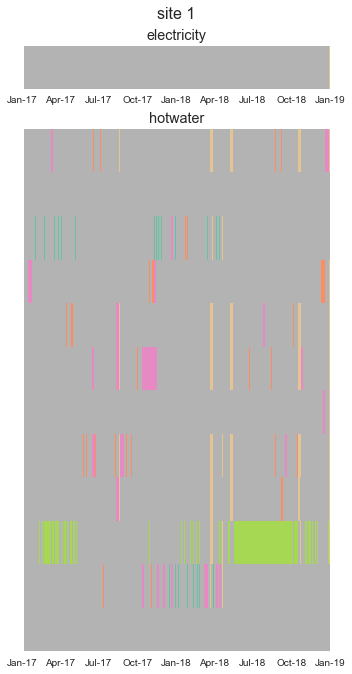

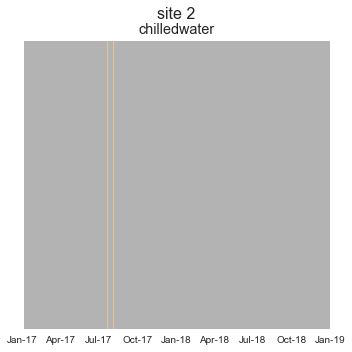

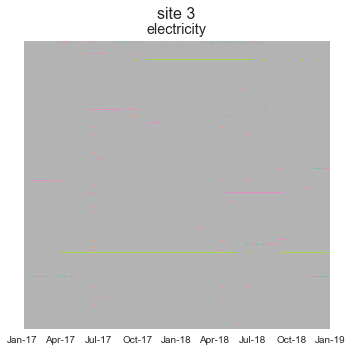

<Figure size 360x1440 with 0 Axes>

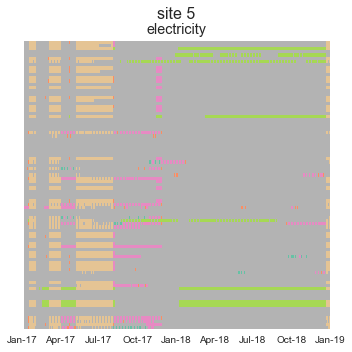

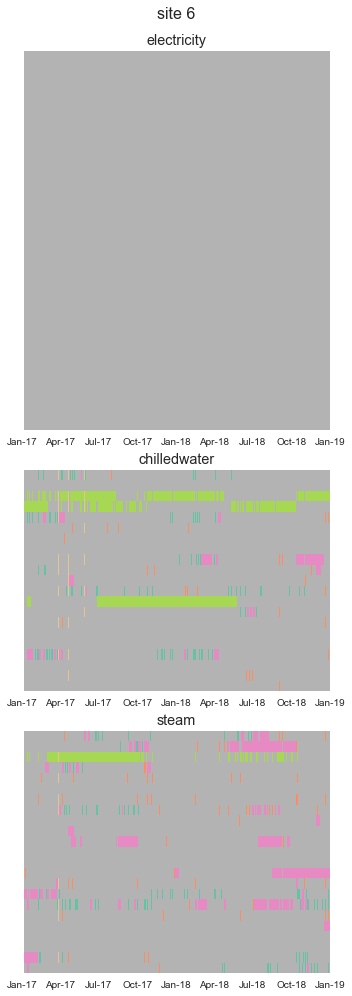

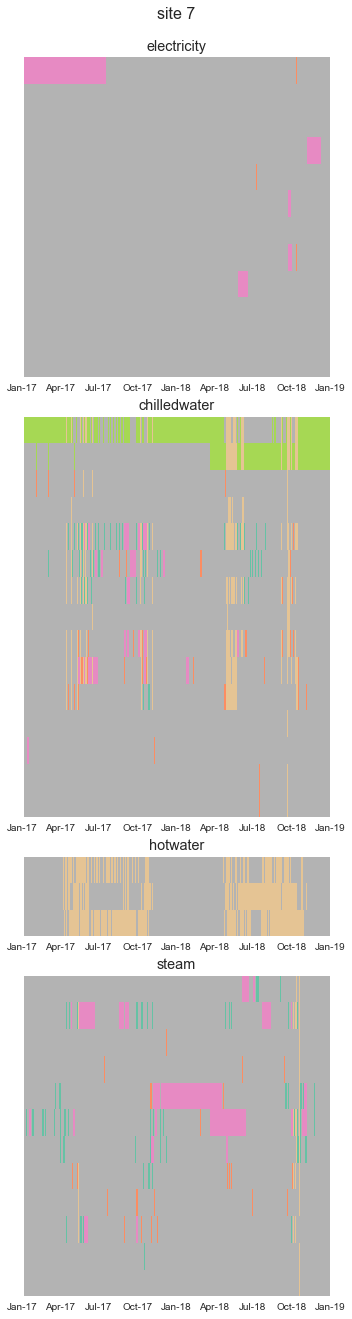

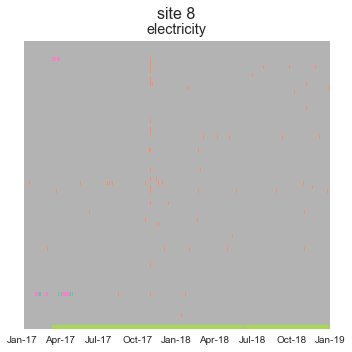

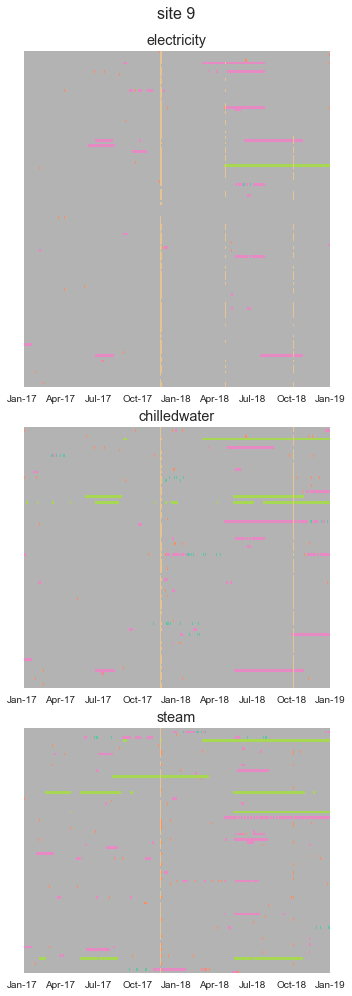

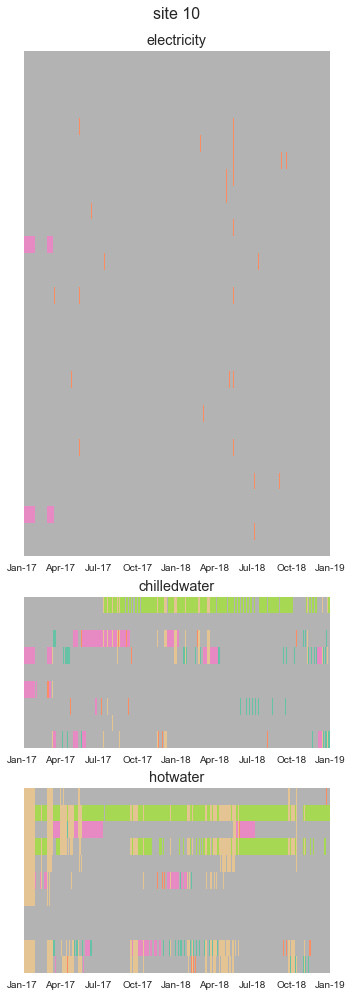

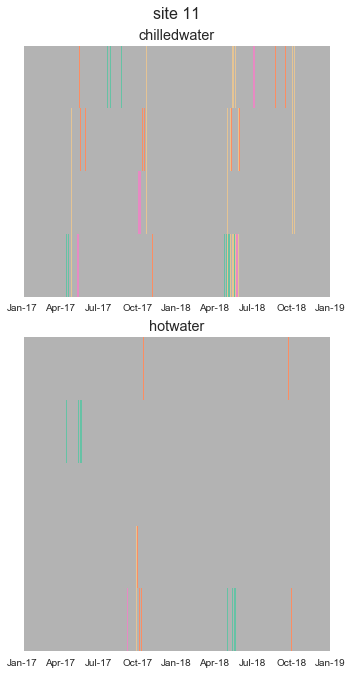

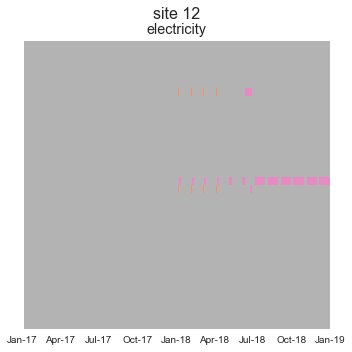

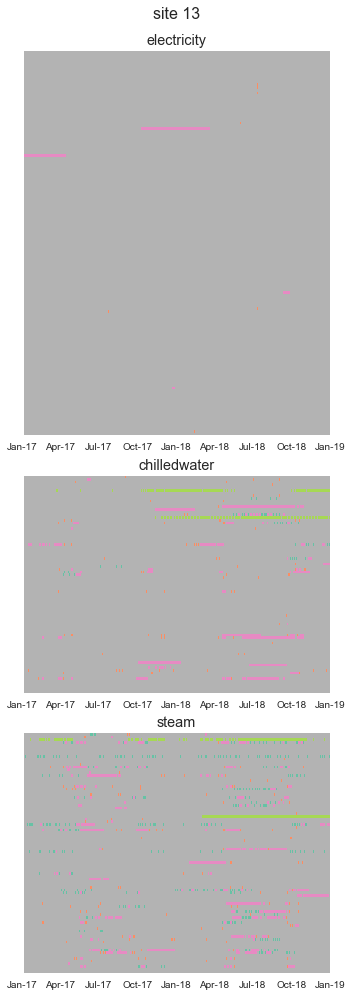

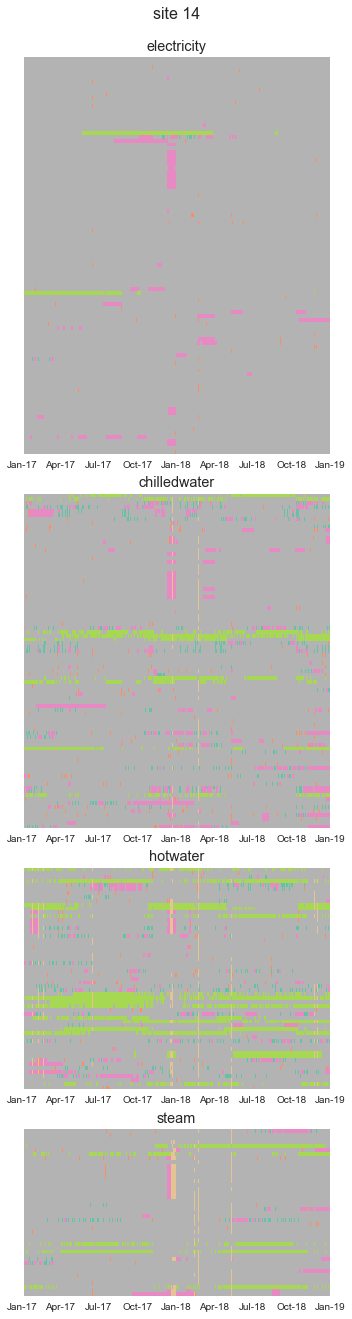

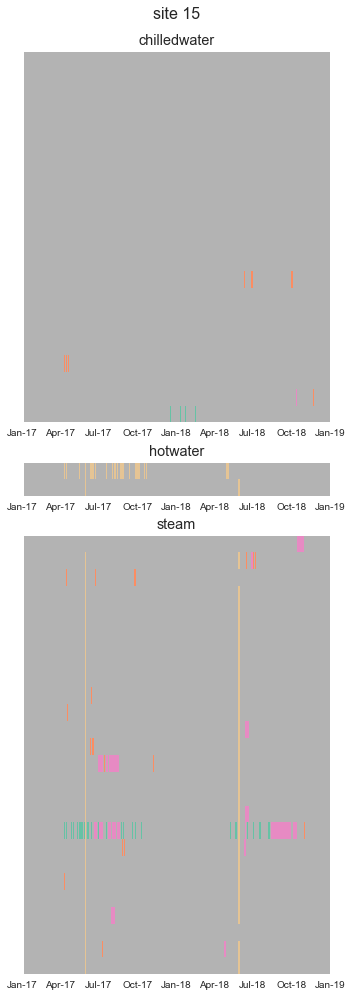

In [22]:
meters = ["electricity","chilledwater","hotwater","steam"]
sites = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

for site in sites:

    print(f"Site {site}")

    df_list = []
    errors_list = []
    meters_list = []

    for meter in meters:

        print(f"Meter: {meter}")

        try:
            df_error, error_types = error_df(path_res, meter, site)
            df_list.append(df_error)
            errors_list.append(error_types)
            meters_list.append(meter)

        except:
            print(f"Site not available for {meter}.")

    cols = 1 #2
    rows = len(df_list)

    # Ratios to make height of subplot dependant of number of buldings
    ratios = [len(df) for df in df_list]

    # Size of figure dependant on number of plots
    figsize = setSize(rows)

    fig, axes = plt.subplots(rows, cols, sharex = False, sharey=False, figsize=figsize, gridspec_kw = {"height_ratios": ratios})#, "width_ratios": [4,1]})
    plots = rows * cols
    axes = axes.flatten() if plots > 1 else axes

    i = 0
    for df,error,meter in zip(df_list, errors_list, meters_list):

        # Color palettes
        errors = sorted(error)
        cmap0 = ListedColormap(cmap)
        cmap1, names1 = choose_palette(error,ref)

        ## HEATMAP
        # Get the data
        y = np.linspace(0, len(df), len(df)+1)
        x = pd.date_range(start='2017-01-01', end='2019-01-01')
        data = df
        # Plot
        ax0 = axes[i] if plots>1 else axes
        qmesh = ax0.pcolormesh(x, y, data, cmap=cmap0, rasterized=True, vmin=0, vmax=5)
        # Axis
        plt.locator_params(axis='y', nbins=len(list(data.index))+1)
        ax0.set_title(f"{meter}")
        ax0.axis('tight') 
        ax0.xaxis_date() # Set up as dates
        ax0.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y')) # set date's format
        ax0.set_yticklabels("") # omit building ID on y axis

        """#BARPLOT
        # Create dataet
        df_melt = df.melt()
        df_melt = df_melt[df_melt.value != 0].groupby("value").count().rename(index=ref).reset_index()
        total = df_melt.variable.sum()
        df_melt["pct"] = [(var/total)*100 for var in df_melt.variable]
        df_melt = df_melt[["value","pct"]].set_index("value").T

        ax1 = axes[i+1]
        bplot = df_melt.plot(kind='bar', stacked=True, color=cmap1, ax=ax1, width=0.5, legend=False)
        list_values = [f"{round(x,1)}%" for x in list(df_melt.values[0])]
        ax1.set_axis_off()
        ax1.set_ylim(0,100)

        for rect, value in zip(bplot.patches, list_values):
            h = rect.get_height() /2.
            w = rect.get_width() /2.
            x, y = rect.get_xy()
            bplot.text(x+w, y+h,value,horizontalalignment='center',verticalalignment='center',size=8)  """   

        i = i+1    

    # Figure parameters
    fig.suptitle(f"site {site}", y = 1.015, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.12)

    fig.savefig(path_fig + f"{site}_allmeters.pdf", dpi=150, bbox_inches="tight")
    fig.savefig(path_fig + f"{site}_allmeters.png", dpi=150, bbox_inches="tight")

# Plots by meter


Meter electricity
Site 0 not available for electricity.
Site 1 not available for electricity.
Site 2 not available for electricity.
Site 3 error's dataframe created.
Site 4 not available for electricity.
Site 5 error's dataframe created.
Site 6 error's dataframe created.
Site 7 error's dataframe created.
Site 8 error's dataframe created.
Site 9 error's dataframe created.
Site 10 error's dataframe created.
Site 11 not available for electricity.
Site 12 error's dataframe created.
Site 13 error's dataframe created.
Site 14 error's dataframe created.
Site 15 not available for electricity.

Meter chilledwater
Site 0 not available for chilledwater.
Site 1 not available for chilledwater.
Site 2 not available for chilledwater.
Site 3 not available for chilledwater.
Site 4 not available for chilledwater.
Site 5 not available for chilledwater.
Site 6 error's dataframe created.
Site 7 error's dataframe created.
Site 8 not available for chilledwater.
Site 9 error's dataframe created.
Site 10 erro

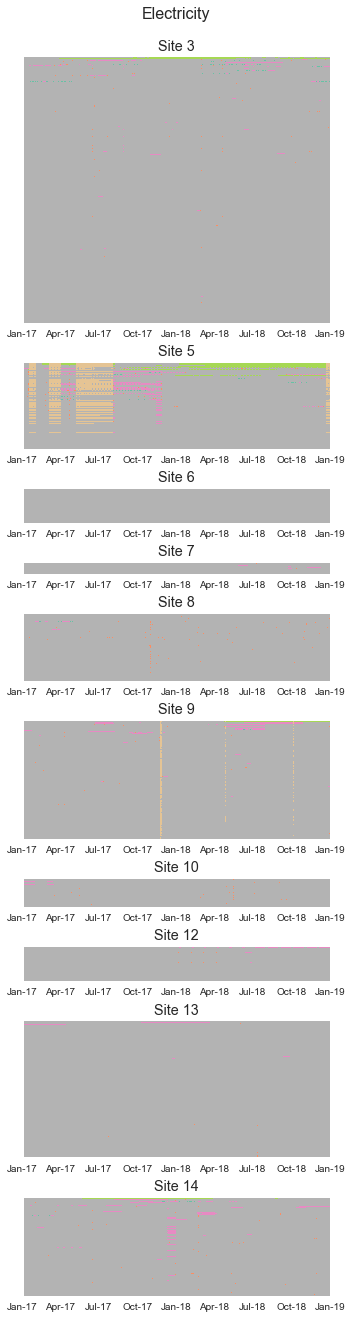

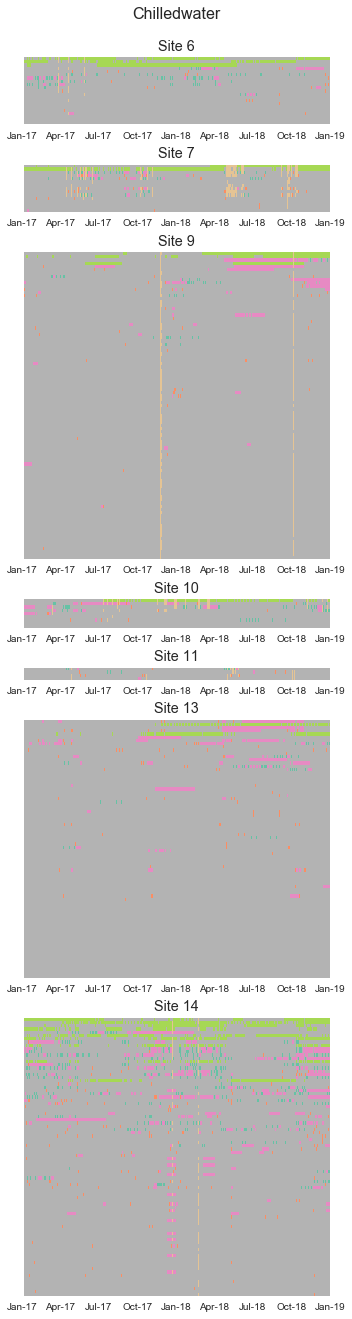

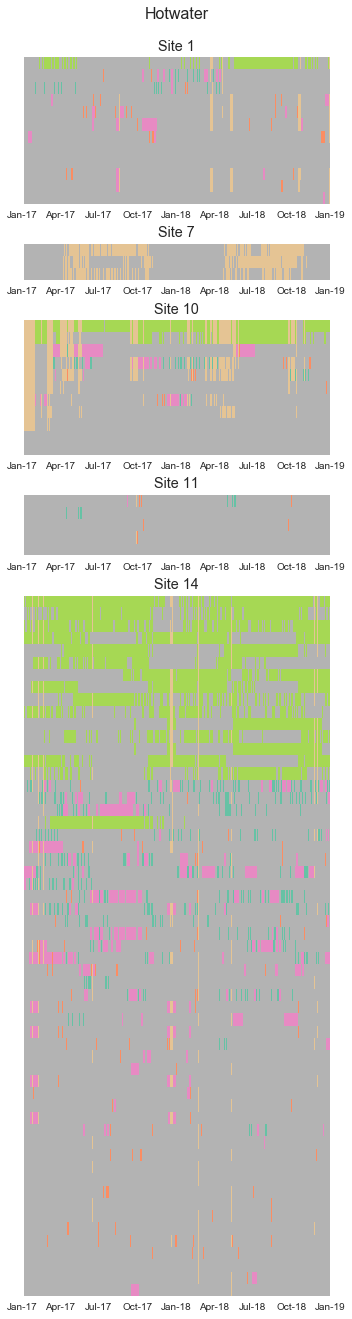

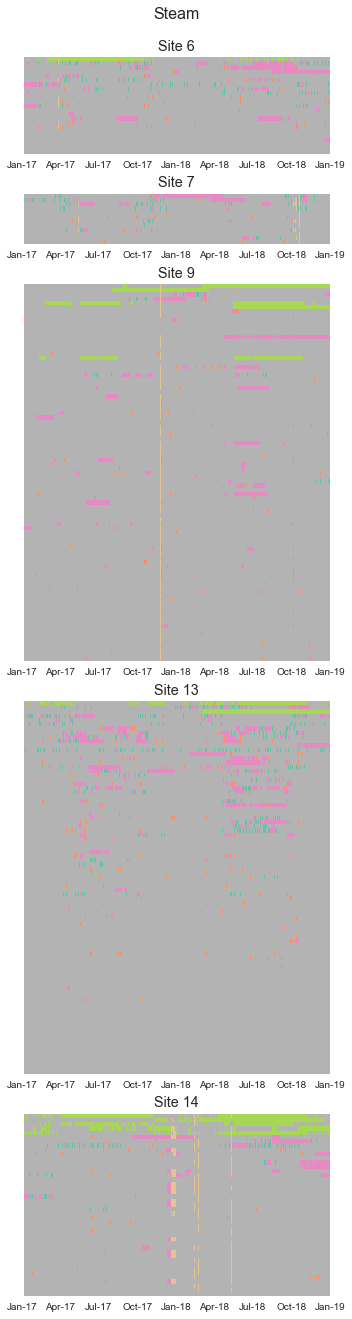

In [13]:
meters = ["electricity","chilledwater","hotwater","steam"]
#meters = ["steam"]
sites = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

for meter in meters:
    print(f"\nMeter {meter}")

    df_list = []
    errors_list = []
    sites_list = []

    for site in sites:

        try:
            df_error, error_types = error_df(path_res, meter, site)
            df_list.append(df_error)
            errors_list.append(error_types)
            sites_list.append(site)

        except:
            print(f"Site {site} not available for {meter}.")

    # Remove sites with only one building
    df_list_filter = []
    sites_list_filter = []
    errors_list_filter = []

    for df,site,error in zip(df_list,sites_list,errors_list):
        if (len(df) > 1):
            df_list_filter.append(df)
            sites_list_filter.append(site)
            errors_list_filter.append(error)

    cols = 1 #2
    rows = len(df_list_filter)

    # Ratios to make height of subplot dependant of number of buldings
    ratios = [len(df) for df in df_list_filter]

    # Size of figure dependant on number of plots
    figsize = setSize(rows)

    fig, axes = plt.subplots(rows, cols, sharex = False, sharey=False, figsize=figsize, gridspec_kw = {"height_ratios": ratios})#, "width_ratios": [4,1]})
    plots = rows * cols
    axes = axes.flatten() if plots > 1 else axes

    i = 0
    for df,error,site in zip(df_list_filter, errors_list_filter, sites_list_filter):

        # Color palettes
        errors = sorted(error)
        cmap0 = ListedColormap(cmap)
        cmap1, names1 = choose_palette(error,ref)

        ## HEATMAP
        # Get the data
        y = np.linspace(0, len(df), len(df)+1)
        x = pd.date_range(start='2017-01-01', end='2019-01-01')
        data = df
        # Plot
        ax0 = axes[i] if plots>1 else axes
        qmesh = ax0.pcolormesh(x, y, data, cmap=cmap0, rasterized=True, vmin=0, vmax=5)
        # Axis
        plt.locator_params(axis='y', nbins=len(list(data.index))+1)
        ax0.set_title(f"Site {site}")
        ax0.axis('tight') 
        ax0.xaxis_date() # Set up as dates
        ax0.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y')) # set date's format
        ax0.set_yticklabels("") # omit building ID on y axis

        i = i+1    

    # Figure parameters
    fig.suptitle(f"{meter.capitalize()}", y = 1.015, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.12)

    #fig.savefig(path_fig + f"{meter}_allsites.pdf", dpi=150, bbox_inches="tight")
    fig.savefig(path_fig + f"{meter}_allsites.png", dpi=150, bbox_inches="tight")


Meter electricity
Site 0 not available for electricity.
Site 1 error's dataframe created.
Site 2 not available for electricity.
Site 3 error's dataframe created.
Site 4 not available for electricity.
Site 5 error's dataframe created.
Site 6 error's dataframe created.
Site 7 error's dataframe created.
Site 8 error's dataframe created.
Site 9 error's dataframe created.
Site 10 error's dataframe created.
Site 11 not available for electricity.
Site 12 error's dataframe created.
Site 13 error's dataframe created.
Site 14 error's dataframe created.
Site 15 not available for electricity.

Meter chilledwater
Site 0 not available for chilledwater.
Site 1 not available for chilledwater.
Site 2 error's dataframe created.
Site 3 not available for chilledwater.
Site 4 not available for chilledwater.
Site 5 not available for chilledwater.
Site 6 error's dataframe created.
Site 7 error's dataframe created.
Site 8 not available for chilledwater.
Site 9 error's dataframe created.
Site 10 error's dataf

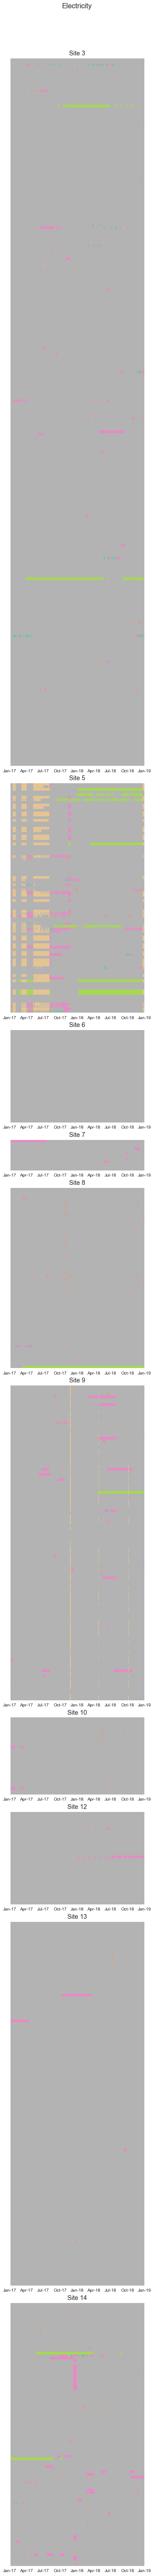

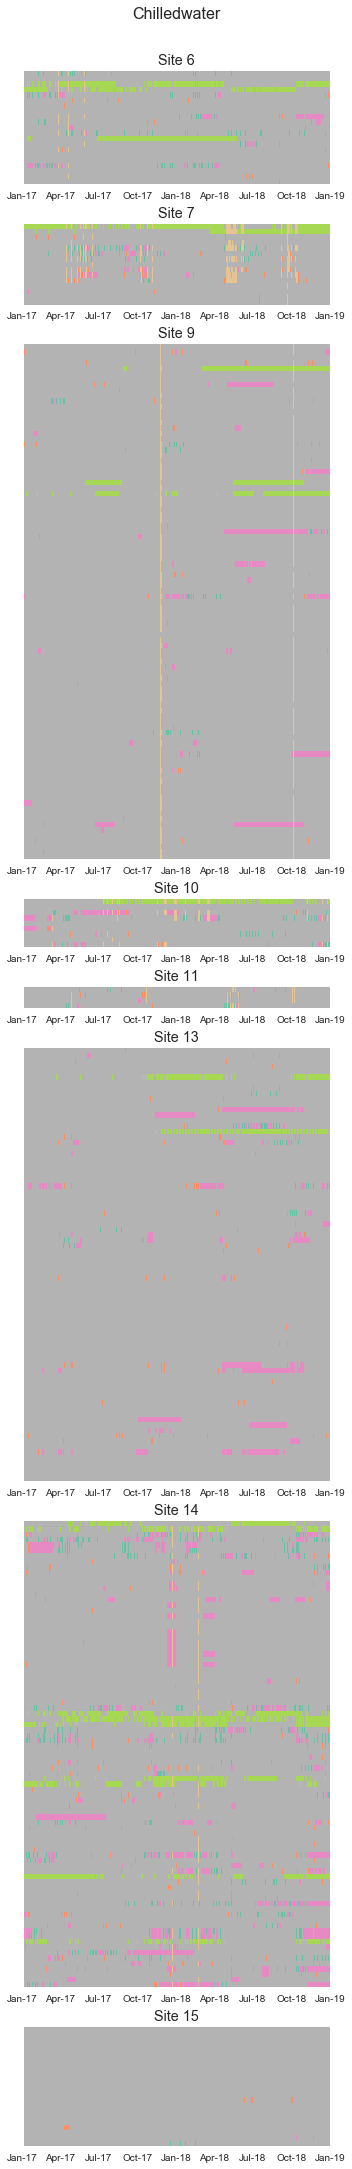

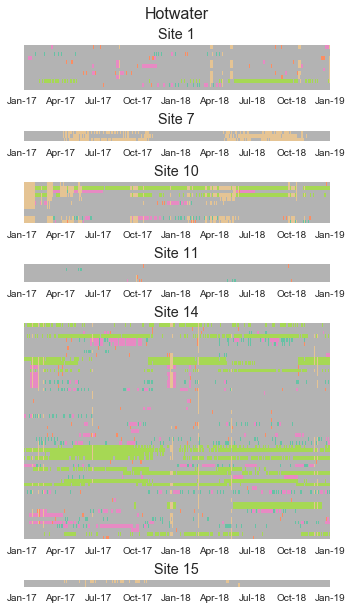

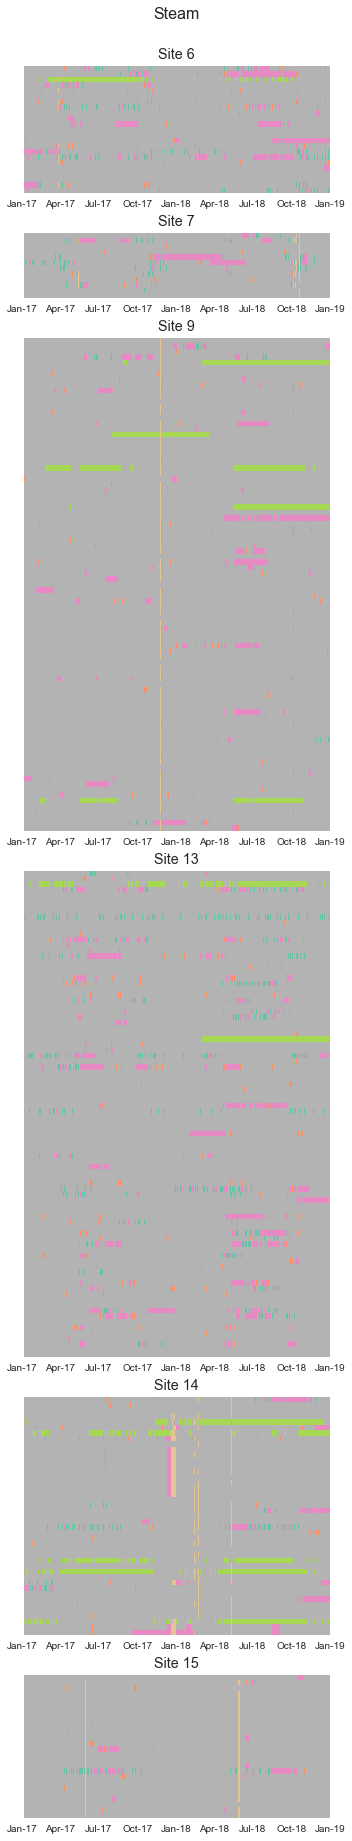

In [13]:
meters = ["electricity","chilledwater","hotwater","steam"]
#meters = ["steam"]
sites = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

for meter in meters:
    print(f"\nMeter {meter}")

    df_list = []
    errors_list = []
    sites_list = []

    for site in sites:

        try:
            df_error, error_types = error_df(path_res, meter, site)
            df_list.append(df_error)
            errors_list.append(error_types)
            sites_list.append(site)

        except:
            print(f"Site {site} not available for {meter}.")

    # Remove sites with only one building
    df_list_filter = []
    sites_list_filter = []
    errors_list_filter = []

    for df,site,error in zip(df_list,sites_list,errors_list):
        if (len(df) > 1):
            df_list_filter.append(df)
            sites_list_filter.append(site)
            errors_list_filter.append(error)

    cols = 1 #2
    rows = len(df_list_filter)

    # Ratios to make height of subplot dependant of number of buldings
    ratios = [len(df) for df in df_list_filter]

    # Size of figure dependant on number of plots
    figsize = (5,sum(ratios)/10)

    fig, axes = plt.subplots(rows, cols, sharex = False, sharey=False, figsize=figsize, gridspec_kw = {"height_ratios": ratios})#, "width_ratios": [4,1]})
    plots = rows * cols
    axes = axes.flatten() if plots > 1 else axes

    i = 0
    for df,error,site in zip(df_list_filter, errors_list_filter, sites_list_filter):

        # Color palettes
        errors = sorted(error)
        cmap0 = ListedColormap(cmap)
        cmap1, names1 = choose_palette(error,ref)

        ## HEATMAP
        # Get the data
        y = np.linspace(0, len(df), len(df)+1)
        x = pd.date_range(start='2017-01-01', end='2019-01-01')
        data = df
        # Plot
        ax0 = axes[i] if plots>1 else axes
        qmesh = ax0.pcolormesh(x, y, data, cmap=cmap0, rasterized=True, vmin=0, vmax=5)
        # Axis
        plt.locator_params(axis='y', nbins=len(list(data.index))+1)
        ax0.set_title(f"Site {site}")
        ax0.axis('tight') 
        ax0.xaxis_date() # Set up as dates
        ax0.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y')) # set date's format
        ax0.set_yticklabels("") # omit building ID on y axis

        i = i+1    

    # Figure parameters
    fig.suptitle(f"{meter.capitalize()}", y = 1.015, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.12)

    fig.savefig(path_fig + f"{meter}_allsites_b.pdf", dpi=150, bbox_inches="tight")
    fig.savefig(path_fig + f"{meter}_allsites_b.png", dpi=150, bbox_inches="tight")

## Plots by selected site

In [9]:
def sites_to_plot(meter):

    if (meter == "chilledwater") or (meter == "steam"):
        sites = [9,13,14]
    elif meter == "electricity":
        sites = [5,9,14]
    elif meter == "hotwater":
        sites = [1,10,14]
    
    return sites


Meter electricity
Site 5 error's dataframe created.
Site 9 error's dataframe created.
Site 14 error's dataframe created.
Total bdgs: 313. Ratios: [0.59, 0.81, 0.68]. Fig height: (15, 2)

Meter chilledwater
Site 9 error's dataframe created.
Site 13 error's dataframe created.
Site 14 error's dataframe created.
Total bdgs: 261. Ratios: [0.63, 0.53, 0.57]. Fig height: (12, 2)

Meter hotwater
Site 1 error's dataframe created.
Site 10 error's dataframe created.
Site 14 error's dataframe created.
Total bdgs: 80. Ratios: [0.08, 0.07, 0.38]. Fig height: (4, 2)

Meter steam
Site 9 error's dataframe created.
Site 13 error's dataframe created.
Site 14 error's dataframe created.
Total bdgs: 220. Ratios: [0.59, 0.59, 0.29]. Fig height: (10, 2)


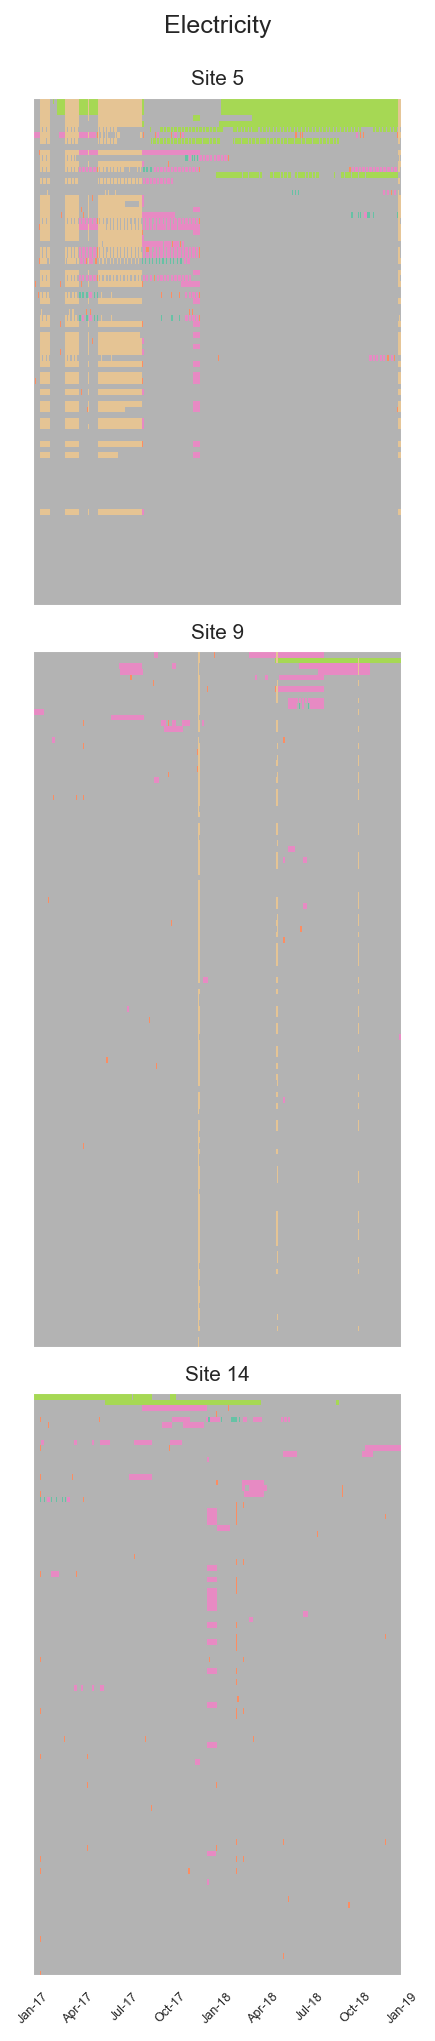

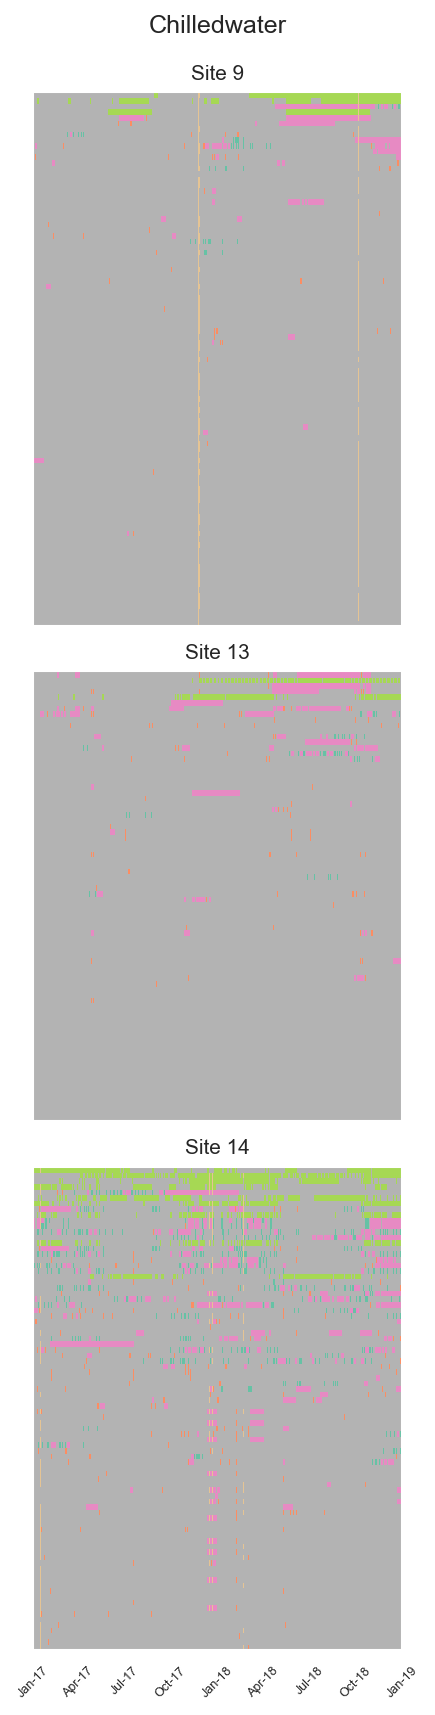

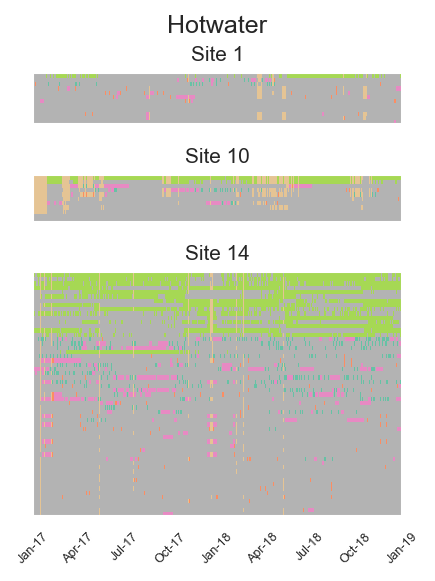

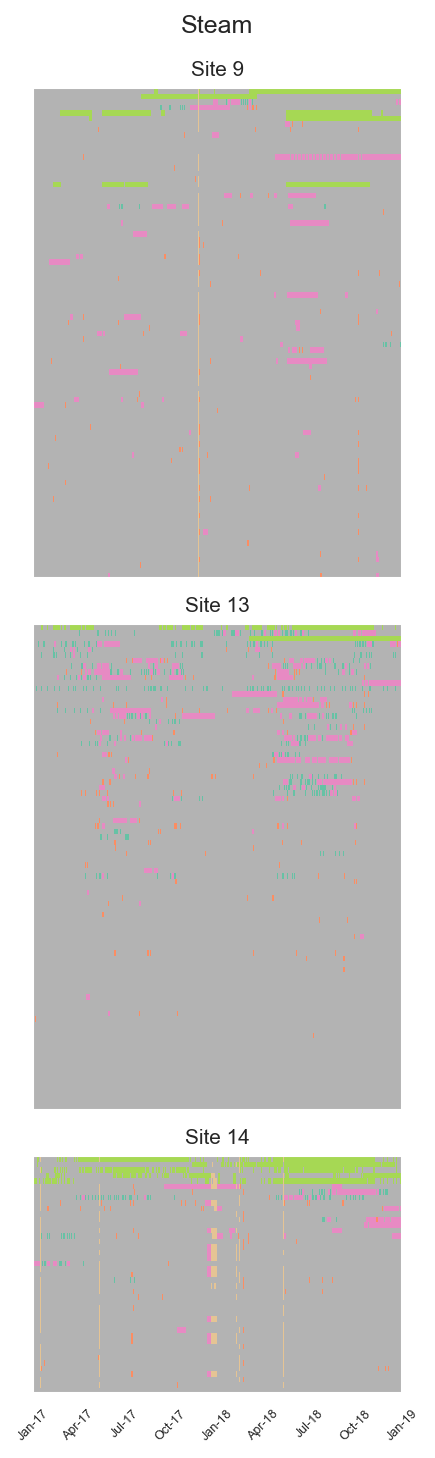

In [27]:
meters = ["electricity","chilledwater","hotwater","steam"]
#meters = ["steam"]

for meter in meters:
    print(f"\nMeter {meter}")

    df_list = []
    errors_list = []
    sites_list = []

    sites = sites_to_plot(meter)
    for site in sites:

        try:
            df_error, error_types = error_df(path_res, meter, site)
            df_list.append(df_error)
            errors_list.append(error_types)
            sites_list.append(site)

        except:
            print(f"Site {site} not available for {meter}.")

    # Remove sites with only one building
    df_list_filter = []
    errors_list_filter = []

    for df,site,error in zip(df_list,sites_list,errors_list):
        if (len(df) > 1):
            df_list_filter.append(df)
            errors_list_filter.append(error)

    cols = 1 #2
    rows = len(df_list_filter)
    dpi = 150
    squaresize = 7
    ratios = [len(df)/dpi for df in df_list_filter]

    total_bdgs = 0
    for j in df_list_filter:
        total_bdgs = total_bdgs + len(j)

    figheight = total_bdgs*squaresize/float(dpi)
    print(f"Total bdgs: {total_bdgs}. Ratios: {[round(r,2) for r in ratios]}. Fig height: {round(figheight),2}")

    # Ratios to make height of subplot dependant of number of buldings
    #ratios = [len(df) for df in df_list_filter]

    # Size of figure dependant on number of plots
    #figsize = setSize(rows)

    fig, axes = plt.subplots(rows, cols, sharex = True, sharey=False, figsize=(3,figheight), dpi=dpi, gridspec_kw = {"height_ratios": ratios})#, "width_ratios": [4,1]})
    plots = rows * cols
    axes = axes.flatten() if plots > 1 else axes

    i = 0
    for df,error,site in zip(df_list_filter, errors_list_filter, sites):

        # Color palettes
        errors = sorted(error)
        cmap0 = ListedColormap(cmap)
        cmap1, names1 = choose_palette(error,ref)

        ## HEATMAP
        # Get the data
        y = np.linspace(0, len(df), len(df)+1)
        x = pd.date_range(start='2017-01-01', end='2019-01-01')
        data = df
        # Plot
        ax0 = axes[i] if plots>1 else axes
        qmesh = ax0.pcolormesh(x, y, data, cmap=cmap0, rasterized=True, vmin=0, vmax=5)
        # Axis
        plt.locator_params(axis='y', nbins=len(list(data.index))+1)
        ax0.set_title(f"Site {site}", fontsize=10)
        ax0.axis('tight') 
        ax0.xaxis_date() # Set up as dates
        ax0.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y')) # set date's format
        #ax0.set_xticklabels(ax0.get_xticklabels(), rotation=45, ha='right',fontsize=8)
        ax0.set_yticklabels("") # omit building ID on y axis
        plt.xticks(rotation=45, fontsize=6)

        i = i+1    

    # Figure parameters
    fig.suptitle(f"{meter.capitalize()}", y = 1.015, fontsize=12)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.12)

    fig.savefig(path_fig + f"{meter}_selectedSites.pdf", dpi=150, bbox_inches="tight")
    fig.savefig(path_fig + f"{meter}_selectedSites.png", dpi=150, bbox_inches="tight")